# Упражнение 1

Рассмотрим краевую задачу для ОДУ:

$$-u''(x) + u(x) = x\\ \\ \\
u(0) = 0\\ \\ \\
u(1) = 0\\ \\ \\
x \in [0, 1]$$

1. Найдите его аналитическое решение.


2. Найдите решение численно, построив конечно-разностную аппроксимацию с шагом сетки $h$ и решив СЛАУ $$A \overrightarrow{x} = \overrightarrow{b},$$ где $A$ - квадратная трехдиагональная матрица, с $\frac{2}{h^2} + 1$ и $-\frac{1}{h^2}$ на диагонали и субдиагоналях соответственно, а $b$ - вектор, который равен $(h, 2h, ..., Nh)^T$. 

    Решите СЛАУ стандартной функцией и сравните полученное решение с аналитическим.
    
    Постройте график зависимости скорости решение СЛАУ от размерности матрицы $A$.


3. Реализуйте метод прогонки для решения данной СЛАУ.

    Постройте график зависимости вемени работы метод от $N$. И сравнить с результатами прошлого метода.



-----
## Решение

1. Найдем аналитически решение ОДУ

    1.1 Найдем общее решение однородного уравнения:
    $$-u''(x) + u(x) = 0\\ \\ \\
    -\lambda ^2 + 1 = 0\\ \\ \\
    \lambda = \pm 1\\ \\ \\ 
    \Rightarrow u(x) = c_1 \cdot e^x + c_2 \cdot e^{-x}$$
    
    1.2 Найдем частное решение неоднородного уравнения:
    
    Будем искать его в виде $$\widetilde{u}(x) = A\cdot x + B$$
        
    Подставим $\widetilde{u}(x)$ в уравнение и найдем неизвестные коэффиценты $A,\ B$:
    $$\\ \\ \\
    A\cdot x + B = x\\ \\ \\
        \Rightarrow A = 1,\ B = 0$$
    Тогда частным решением неоднородного уравнения является:
    $$\\ \\ \\
    \widetilde{u}(x) = x$$
    
    1.3 Общее решение уравнения получается как сумма решений общего однородного и частного неоднородного:
    $$\\ \\ \\
    u(x) = c_1 \cdot e^x + c_2 \cdot e^{-x} + x$$
    
    1.4 Подставим в решение краевые условия, чтобы найти значения $c_1,\ c_2$.
    $$\\ \\ \\
    u(0) = c_1 + c_2 = 0\\ \\ \\
    u(1) = c_1 \cdot e + c_2 \cdot e^{-1} + 1 = 0$$
    
    Решив эту систему уравнений, получаем:
    $$c_1 = -\frac{e}{e^2 + 1},\\ \\ \\
    c_2 = \frac{e}{e^2 + 1}$$
    
    1.5 Итоговое решение краевой задачи:
    $$u(x) = -\frac{e}{e^2 + 1}\cdot e^x + \frac{e}{e^2 + 1}\cdot e^{-x} + x$$
    
----

2. Решим СЛАУ, используя $LU-$разложение матрицы $A$.

In [289]:
from functools import partial
import math
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import numpy as np
import time
from typing import List, Callable

Matrix = List[List[float]]
Vector = List[float]

In [67]:
def lu_decomposition(A: Matrix) -> (Matrix, Matrix):
    n = len(A)
    L = [[0] * n for _ in range(n)]
    U = [[0] * n for _ in range(n)]
    
    for i in range(n):
        for j in range(i, n):
            
            if (i == 0):
                U[i][j] = A[i][j]
                if U[0][0] != 0:
                    L[j][i] = A[j][0] / U[0][0]
            else:              
                tmp_u = 0
                tmp_l = 0
                for k in range((i - 1) + 1):
                    tmp_u += L[i][k] * U[k][j]
                    tmp_l += L[j][k] * U[k][i]
                
                U[i][j] = A[i][j] - tmp_u
                if U[i][i] != 0:
                    L[j][i] = (1. / U[i][i]) * (A[j][i] - tmp_l)
                    
    return L, U

In [206]:
def lower_triangular_solve(L: Matrix, b: Vector) -> Vector:
    n = len(L)
    y = [0] * n
     
    for row in range(n):        
        tmp_l_y = 0
        for k in range(row):
            tmp_l_y += L[row][k] * y[k]
            
        y[row] = (b[row] - tmp_l_y) / L[row][row]
    
    return y

In [205]:
def upper_triangular_solve(U: Matrix, y: Vector) -> Vector:
    n = len(U)
    x = [0] * n
    
    for row in range(n - 1, -1, -1):        
        tmp_u_x = 0
        for k in range((n - 1) - row):
            tmp_u_x += U[row][n - 1 - k] * x[n - k - 1]
        
        x[row] =  (y[row] - tmp_u_x) / U[row][row]
        
    return x

In [201]:
def generate_A_matrix(N: int, h: float) -> Matrix:
    A = [[0] * N for _ in range(N)]

    for i in range(N):
        A[i][i] = 1 + 2. / h ** 2
        if i - 1 > 0:
            A[i][i - 1] = - 1. / h ** 2
        if i + 1 < N:
            A[i][i + 1] = - 1. / h ** 2
    
    return A

In [182]:
def generate_b_vector(N: int, h: float) -> Vector:
    return [i * h for i in range(1, N + 1)]

In [266]:
timestamps_for_lu = []

@timestamps(timestamps_for_lu)
def lu_solver(A: Matrix, b: Vector) -> Vector:
    L, U = lu_decomposition(A)
    y = lower_triangular_solve(L, b)
    x = upper_triangular_solve(U, y)
    
    return x

In [265]:
def solve_this_differential_equation(N: int, h: float) -> Vector:
    A = generate_A_matrix(N, h)
    b = generate_b_vector(N, h)
    
    x = lu_solver(A, b)
    
    #print('actual = ', mv(A, x), '\n', 'expected = ', b)
    
    return x

In [169]:
def acc_solution_in_point(t: float) -> float:
    c_1 = - (math.exp(1)) / (math.exp(2) + 1)
    
    return c_1 * math.exp(t) - c_1 * math.exp(-t) + t

In [179]:
def acc_solution(N: int, h: float) -> Vector:
    return [acc_solution_in_point(i * h) for i in range(1, N + 1)]

In [193]:
def error_betweet_num_and_acc(num: Vector, acc: Vector) -> Vector:
    N = len(num)
    return [abs(num[i] - acc[i]) for i in range(N)]

In [194]:
def plot_num_acc_error(t, acc, num, error):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(t, acc, 'g.-')
    plt.ylabel('accurate')
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(t, num, 'k.-')
    plt.ylabel('numerical')
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.plot(t, error, 'r.-')
    plt.ylabel('error')
    plt.grid()
    
    plt.show()

In [228]:
N = 150
h = 1. / (N + 1)

num = solve_this_differential_equation(N, h)
acc = acc_solution(N, h)
error = error_betweet_num_and_acc(num, acc)
t = [i * h for i in range(1, N + 1)]

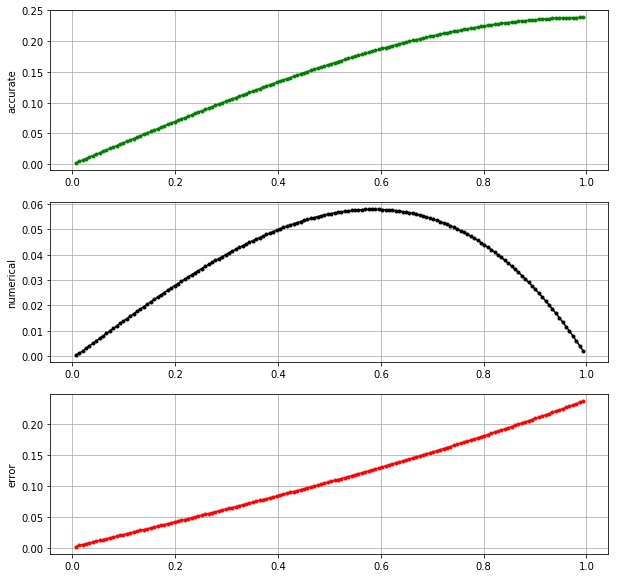

In [200]:
plot_num_acc_error(t, acc, num, error)

3. Реализуем метод прогонки.
$$
 \begin{pmatrix}
  b_1 & c_1 &  & & 0 \\
  a_2 & b_2 &  c_2 & &  \\
  & a_3 & b_3 &  \ddots &   \\
   && \ddots  & \ddots & c_{n - 1}  \\
  0 & & & a_n & b_n 
 \end{pmatrix} \cdot
 \begin{pmatrix}
  x_1  \\
  x_2  \\
  x_3 \\
  \vdots \\
  x_n
 \end{pmatrix} = 
 \begin{pmatrix}
  d_1  \\
  d_2  \\
  d_3 \\
  \vdots \\
  d_n
 \end{pmatrix}$$
 
     Тогда вспомогательные коэффициенты можно найти по формуле: 
 
 $$c'_i =
  \begin{cases}
    \frac{c_i}{b_i}      & \quad \text{if } i = 1 \\
    \frac{c_i}{b_i - a_i c'_{i - 1}}  & \quad \text{if } i = 2, 3, ..., n - 1 
  \end{cases}\\ \\ \\
  d'_i = 
  \begin{cases}
    \frac{d_i}{b_i}      & \quad \text{if } i = 1 \\
    \frac{d_i - a_i d'_{i - 1}}{b_i - a_i c'_{i - 1}}  & \quad \text{if } i = 2, 3, ..., n 
  \end{cases}
  $$
  
    И искомый вектор $x$ можно будет найти по формуле:
  $$x_n = d'_n\\ \\ \\
  x_i = d'_i - c'_i \cdot x_{i + 1}$$

In [261]:
timestamps_for_tridiag = []

@timestamps(timestamps_for_tridiag)
def tridiagonal_matrix_algorithm(A: Matrix, d: Vector) -> Vector:
    n = len(A)
    c_hatch = [0] * n
    d_hatch = [0] * n
    x = [0] * n
    
    for i in range(n):
        b = A[i][i]
        
        if i == 0:
            c = A[i][i + 1]
            c_hatch[i] = float(c / b)
            d_hatch[i] = float(d[i] / b)
        else:
            a = A[i][i - 1]
            if i < n - 1:
                c = A[i][i + 1]
                c_hatch[i] = float(c / b - a * c_hatch[i - 1])
            
            d_hatch[i] = float((d[i] - a * d_hatch[i - 1]) / (b - a * c_hatch[i - 1]))
            
    for i in range(n - 1, -1, -1):
        if i == n - 1:
            x[i] = d_hatch[i]
        else:
            x[i] = d_hatch[i] - c_hatch[i] * x[i + 1]
    
    return x

In [271]:
#for testing
def mv(A: Matrix, x: Vector) -> Vector:
    n = len(A)
    result = [0] * n
    
    for i in range(n):
        tmp = 0
        for j in range(n):
            tmp += A[i][j] * x[j]
        
        result[i] = tmp
    
    return result

3.2 Сделаем замеры скорости выполнения обоих методов в зависимости от $N$.

In [278]:
def parametrized(dec):
    def layer(*args, **kwargs):
        def repl(f):
            return dec(f, *args, **kwargs)
        return repl
    return layer

@parametrized
def timestamps(f, container: List[float]):
    def aux(*xs, **kws):
        start = time.time_ns()
        f(*xs, **kws)
        end = time.time_ns()
        return container.append(end - start)
    return aux

In [280]:
def benchmark(N_all: List[int]) -> (Vector, Vector):
    global timestamps_for_lu
    global timestamps_for_tridiag
    
    timestamps_for_lu.clear()
    timestamps_for_tridiag.clear()
    
    for n in N_all:
        A = generate_A_matrix(n, 1. / (n + 1))
        b = generate_b_vector(n, 1. / (n + 1))
        
        lu_solver(A, b)
        tridiagonal_matrix_algorithm(A, b)
    
    return timestamps_for_lu, timestamps_for_tridiag        

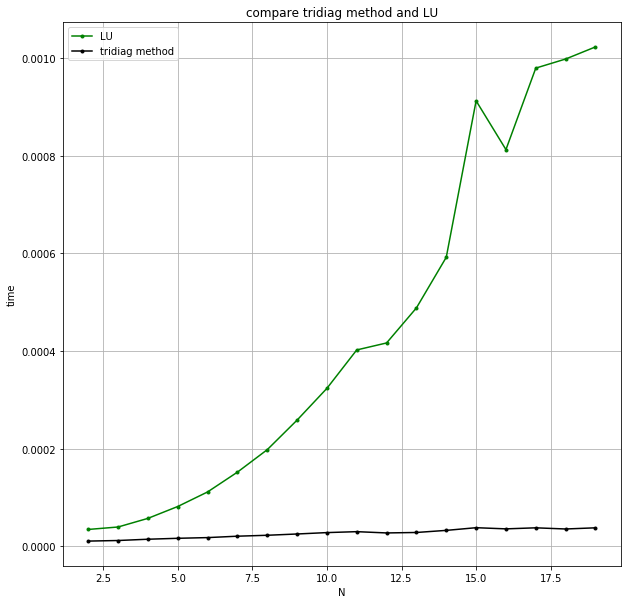

In [294]:
import warnings
warnings.filterwarnings("ignore")

N_min = 2
N_max = 20
step = 1
N_all = np.arange(N_min, N_max, step)

lu_time, tridiag_time = benchmark(N_all)
plt.figure(figsize=(10, 10))
plt.title("compare tridiag method and LU")
plt.xlabel("N")
plt.ylabel("time")
line1 = plt.plot(N_all, lu_time, 'g.-', label="LU")
line2 = plt.plot(N_all, tridiag_time, 'k.-', label="tridiag method")
plt.legend([line1, line2], ["a", "b"])
ax = plt.subplot(111)
ax.legend()
plt.grid()


plt.show()